In [33]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import * #You will probably need this to get some additional functions used here.

In [14]:
from pathlib import Path
!pip install -Uqq duckduckgo-search
from duckduckgo_search import DDGS #This is the new form of search_images_ddg()
from fastcore.all import * #This one has the "L" library needed for the image stuff in the next function.

from fastai.vision.utils import download_images, resize_images

In [25]:
# so search_images_ddg is deprecated, so I used this form again, from my "Is_it_SonicTheHedgehog" notebook
def search_images_ddg(term, max_images=30):
    with DDGS() as ddgs:              #This is the new form of the search_images_ddg by DuckDuckGo that doesn't seem to work anymore.
      search_results = ddgs.images(
          keywords=term,              #Your search term
          max_results = max_images    #How many images you want back
      )
      print(f"{term}: Search result successful")
      #[item["image"] for item in results] The line below is equivalent to this
      images = (              # The parenthesis is so that python allows us to make a multi-line statement.
          L(search_results)   # L will create a fast.ai List object, which has additional functions
          .itemgot("image")   # Here we just want the "image" property.
      )
      return images

In [23]:
# The previous function downloads images using a search term, and a max number of images
# This function will use it to pass multiple search queries, and create a path to save each one.
def get_and_download_images(searches_tuple, path_to_create):
  if not path_to_create.exists():
    path_to_create.mkdir(exist_ok=True)
    for o in searches_tuple:
      dest = (path_to_create/o)
      dest.mkdir(exist_ok=True)                     #Create the path folder
      results = search_images_ddg(f"{o} photo")     #Our function!
      download_images(dest, urls=results[:200])     #Provided by fastai.vision.utils
      resize_images(dest, max_size=400, dest=dest)  #Provided by fastai.vision.utils

In [24]:
#What are we searching for?

searches = ("forest", "bird")
path = Path("bird_or_not") #in which folder are we adding this stuff!

get_and_download_images(
    searches_tuple=searches,
    path_to_create=path
  )

Search result successful
Search result successful


## DataBlock, an introduction
So this is an API to specify how you want your data to be processed.
In essence you can specify 5 things...
- BLOCKS: Specify INPUT and OUTPUT block | blocks=(inputBlock, outputBlock)
- HOW to get the inputs | get_items= someFunction()
- HOW to get the outputs | get_y= someFunction()
- HOW to split the data | splitter = someFunction() (or object() ? )
- TRANSFORMATIONS: What operations to apply to the data (preprocessing)
  - item_tfms=...
  - batch_tfms=...


In [28]:
from fastai.vision.all import * #The DataBlock comes from here, presumably ImageBlock and CategoryBlock do as well

Total images: 59
bird_or_not/forest/16646b4a-a3df-49a7-a344-b03052022487.jpg → label: forest
bird_or_not/forest/6ec80017-dc88-4892-87a0-54a9e67e7454.jpeg → label: forest
bird_or_not/forest/9152d0cd-5ea4-45b4-a339-2535b88a187f.jpg → label: forest
bird_or_not/forest/d30526d0-8d6e-4900-82bf-c9c22402a342.jpg → label: forest
bird_or_not/forest/9b20cc2b-3d36-4d2b-8d8f-126afe0b51b2.jpg → label: forest
[Path('bird_or_not/forest'), Path('bird_or_not/bird')]
forest: 30 images
bird: 29 images


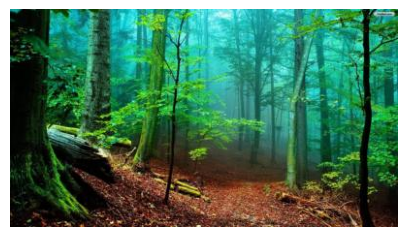

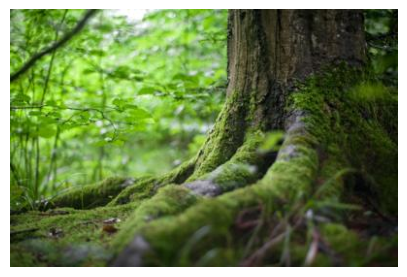

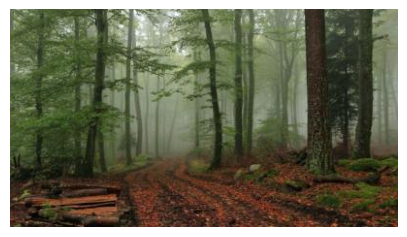

In [66]:
#??get_image_files #You can also check these pre-built functions like so.
#??parent_label
# Check image count
files = get_image_files(path)
print(f"Total images: {len(files)}")
for f in files[:5]:
    print(f, "→ label:", parent_label(f))

for f in files[:3]:
  try:
      img = PILImage.create(f)
      img.show()
  except Exception as e:
      print(f"{f} is broken: {e}")

def verify_images_gpt(files):
  for f in files:
    try:
        _ = PILImage.create(f)
    except Exception as e:
        print(f"Removing {f} → Error: {e}")
        f.unlink()

verified_imgs = verify_images_gpt(files)

print(list(path.ls()))
for sub in path.ls():
    print(f"{sub.name}: {len(get_image_files(sub))} images")

In [100]:
#Let's create a DataBlock object to tell our model how we want the data to be loaded
def create_dataloader(data_path):
  datablock = DataBlock( #DataBlock
      blocks=(ImageBlock, CategoryBlock),
      get_items=get_image_files,
      get_y=parent_label,
      splitter=RandomSplitter(
        valid_pct=0.2,  # This is the percentage that will be put aside for a validation set
        seed=42         # The random seed for splitting, for reproducibility
      ),
      item_tfms = [
          Resize(192, method="squish")
      ]
      #batch_tfms = [
      #    Resize(192, method="squish")
      #]
  )
  dataloader = datablock.dataloaders(
      data_path,
      bs=8 #We reduced the batch size, since there are few pictures!
    )
  return dataloader

In [101]:
# Let's check that everything is alright
print(path)
pathpath = f"./{path}"
dls = create_dataloader(pathpath)
print("Train size:", len(dls.train))
print("Valid size:", len(dls.valid))

bird_or_not
Train size: 6
Valid size: 2


## Seeing a batch
Now you can see a batch as well!

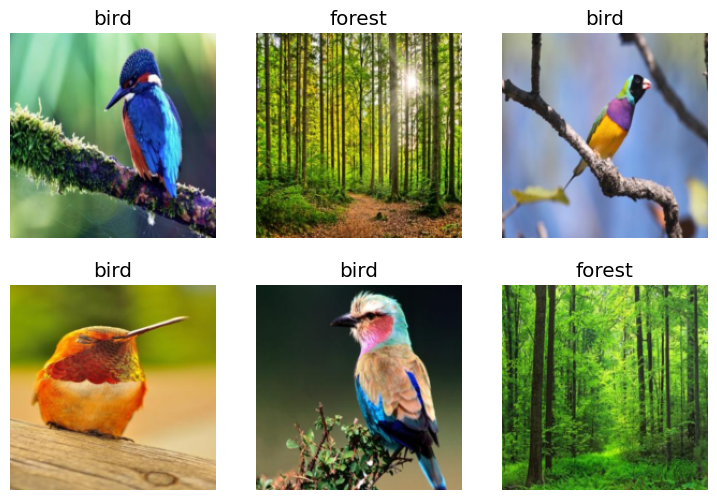

In [105]:
dls.show_batch(max_n=6)

## TRAINING
Now we see that fast.ai provides a training function, in which we pass
- The "Experience": the dataset we got with labels
- The Architecture: resnet18
- The Performance Measure: we choose the Error rate as a metric. My guess is that this is pre-built.

The cnn_learner function will add a new HEAD on the resnet18 (or whatever architecture is chosen)
then fine_tune(3) says...
- for ONE epoch just train the new head, with the rest of the network frozen
- for the REST of the epochs fine-tune the entire network.



In [106]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 42.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.336148,0.063979,0.000000,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.016771,0.005850,0.000000,00:14
1,0.015384,0.003135,0.000000,00:13
2,0.012774,0.001941,0.000000,00:13


## Side-Note: How fast.ai implements AdamW
An optimizer for Adam with lr, mom, sqr_mom, eps, and params

In [ ]:
def weight_decay(p, learning_rate, weight_dec, do_weight_dec=True, **kwargs):
  if do_weight_dec:
    p.data.mul_(1 - learning_rate * weight_dec)
    return p
weight_decay.defaults = dict(weight_dec=0.)

In [ ]:
steppers = [] if weight_dec==0. else [weight_decay] if decouple_weight_dec else [l2_reg]
steppers.append(adam_step)
stats = [partial(average_grad, dampening=True), average_sqr_grad, step_stat]
return Optimizer(params, steppers, stats=stats, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=weight_dec)

## Moving on - Prediction

This is a bird
Probability it's a bird: 1.0000


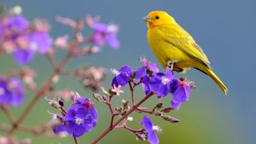

In [112]:
is_bird, _, probs = learn.predict(PILImage.create("/content/bird_or_not/bird/04713cf6-869c-4e34-8a48-c63c29c3f42e.jpg"))
print(f"This is a {is_bird}")
print(f"Probability it's a bird: {probs[0]:.4f}")
im = Image.open("/content/bird_or_not/bird/04713cf6-869c-4e34-8a48-c63c29c3f42e.jpg")
im.to_thumb(256,256)

In [109]:
# Here's another learner trained.
# vlearn = vision_learner(dls, resnet18, metrics=error_rate)
# vlearn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.560451,0.126242,0.090909,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.122587,0.016416,0.000000,00:12
1,0.123037,0.003968,0.000000,00:12
2,0.080081,0.001646,0.000000,00:11


## Other kinds of models
Beyond Image Recognition, there's SEGMENTATION

You color every pixel depending on what it belongs to.
For the training data, someone has gone and done it by hand.

In [113]:
#path = untar_data(URLS.CAMVID_TINY)
#dls_segmentation = SegmentationDataLoaders.from_label_func(
#  path, bs=8, fnames=get_image_files(path/"images"),
#  label_func=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
#  codes = np.loadtxt(path/'codes.txt', dtype=str)
#)

#learn_segmentation = unet_learner(dls, resnet34)
#learn_segmentation.fine_tune(8)
#learn_segmentation.show_results(max_n=5, figsize=(7,8))

This approach is simpler than before. DataBlocks are very flexible to handle. But there are also Special DataLoaders classes for some task.

Instead here you're passing the data through passing the function to get the images, I think.

Basic info provided is similar though, same for creating hte model. You create the net and then fine-tune it.

## Tabular Analysis
Take a spreadsheet or a database table and try to predict columns of those.



In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE) #downloads and decompresses some data for you.
#fast.ai provides a collection of URLs for commonly-used datasets for learning.

dls = TabularDataLoaders.from_csv(
    path/'adult.csv',
    path=path,
    y_names = "salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation','relationship', 'race', 'education-num_na'], #Categorical columns
    cont_names = ['age', 'fnlwgt', 'education-num'], #Continuous columns
    procs=[Categorify, FillMissing, Normalize]
)

# This dataset is of whether people have less or more than 50k salary for different districts,
# based on demographic information of a district.

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2) #not fine-tune

#For this there's no pre-trained model to use, since all tables are more different than pictures.
# So it doesn't quite make sense to say fine_tune.

## Collaborative Filtering - Recommendation System
Says: which users like which products.
We use that to guess which OTHER products a user might like based on that.

Here similarity is not demographic, but people that liked similar products.

In [115]:
from fastai.collab import *
path3 = untar_data(URLs.ML_SAMPLE)
dls3 = CollabDataLoaders.from_csv(path3/'ratings.csv')

dls3.show_batch()

,userId,movieId,rating
0,15,153,1.0
1,457,58559,0.5
2,19,165,3.0
3,481,5349,3.0
4,388,1089,4.0
5,457,356,3.5
6,187,480,3.5
7,544,1240,4.5
8,111,2396,4.0
9,311,260,4.0


In [117]:
learnc = collab_learner(
    dls3,
    y_range=(0.5, 5.5) #This is the prediction range. Although it is actually [1, 5], we give it a bit more range
  )
learnc.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.516248,1.391048,00:00


epoch,train_loss,valid_loss,time
0,1.377849,1.338985,00:00
1,1.300696,1.185446,00:00
2,1.092391,0.889967,00:00
3,0.864801,0.696226,00:00
4,0.713679,0.641097,00:00
5,0.684896,0.622748,00:00
6,0.635970,0.615759,00:00
7,0.647026,0.615228,00:00
8,0.611867,0.613526,00:00
9,0.612784,0.613283,00:00


Again here the term "fine_tune" doesn't fit, fit_one_cycle should work as well

In [118]:
learnc.show_results()

,userId,movieId,rating,rating_pred
0,9.0,74.0,2.0,3.251611
1,16.0,73.0,4.0,4.130290
2,44.0,66.0,4.0,4.022270
3,74.0,43.0,3.0,3.764966
4,94.0,57.0,4.0,4.262138
5,18.0,81.0,2.0,3.866222
6,38.0,74.0,4.0,3.915441
7,82.0,52.0,4.0,3.891826
8,99.0,98.0,4.0,4.347265
